### Validation schema

In [113]:
# linear algebra
import numpy as np

#working with data in table structers
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt


# working with files
import sys
import os

# to off warnings
import warnings
warnings.filterwarnings('ignore')

# validation schema 
import time
from datetime import timedelta, datetime
from sklearn.model_selection import TimeSeriesSplit
from collections import defaultdict
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform


# models
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
import catboost as cb

In [114]:
# # using ray engine for parallel calculation(for oprimization)
# %env MODIN_ENGINE=ray
# import modin.pandas as mpd

### Read data

In [115]:
# add data path to sys.path 
train_test_data_path = "C:\\Repository\\DS-Intership-data\\train_test_data\\"
sys.path.append(train_test_data_path)

# initiate dict for data
to_read_train_test_data = {}

# fill to_read
for dir_name, _, files in os.walk(train_test_data_path):
    for file in files:
        to_read_train_test_data[file] = dir_name + file

In [116]:
# check to_read
to_read_train_test_data

{'submission_example.csv': 'C:\\Repository\\DS-Intership-data\\train_test_data\\submission_example.csv',
 'test_data.csv': 'C:\\Repository\\DS-Intership-data\\train_test_data\\test_data.csv',
 'train_data.csv': 'C:\\Repository\\DS-Intership-data\\train_test_data\\train_data.csv'}

In [117]:
%%time
data = {}
# read data
for file, path in to_read_train_test_data.items():
    data[file.split('.')[0]] = pd.read_csv(os.path.join(os.path.dirname(path), file), index_col=0)

CPU times: total: 24.3 s
Wall time: 26.3 s


### Validation schema

In [6]:
"""
    The following indexes will be used:
        
        from train_data:
          date_block_num
          shop_id
          item_category_id
          item_id
          item_cnt_month
        
        from test_data:
            shop_id',
            'item_id',
            'ID'

    Concept:
        Apply expanding window validation (except last month - target of competition)
        Monthly predictions
"""

class Validation:
    def __init__(self,
                 train_data,
                 test_data,
                 submission_example,
                 metrics=['rmse'],
                 n_splits=5,
                 model=DecisionTreeRegressor(max_depth=1, random_state=42),
                 check_nans = True,
                 dropna = False,
                 check_infs = True, 
                 plot=True
                ):
        self.train_data = train_data
        self.test_data = test_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.n_splits = n_splits
        self.model = model
        self.plot = plot
        self.tscv = TimeSeriesSplit(n_splits=self.n_splits)

        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_category_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_category_id',
                    'item_id',
                   ]).issubset(test_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"
        
        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.test_data = self.test_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
        if check_nans:
            assert self.test_data.isna().sum().sum() == 0, 'Test data have NaNs'
        if check_infs:
            assert np.isfinite(self.test_data).sum().sum() != 0, 'Test data have Infs'
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
            
        # Split to X and y
        self.X = self.train_data.drop(columns='item_cnt_month')
        self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
        # Validation process visualisation
        if self.plot:
            split_history = {
                'Step': ["Step"+str(i) for i in range(1, self.n_splits+1)],
                'Train Data': [], 
                'Validation Data': []
            }
            for train, val in self.tscv.split(self.train_data[['item_id', 'shop_id', 'item_cnt_month']]):    
                split_history['Train Data'].append(train.max()-train.min())
                split_history['Validation Data'].append(val.max()-val.min())
            df = pd.DataFrame(split_history)
            print(df)
            sns.set(style="whitegrid")
            plt.figure(figsize=(6, 5))
            sns.barplot(x='Step', y='Train Data', data=df, color='skyblue', label='Train Data')
            sns.barplot(x='Step', y='Validation Data', data=df, color='salmon', label='Validation Data', bottom=df['Train Data'])
            plt.title('Distribution of data for training and validation')
            plt.xlabel('Validation step')
            plt.ylabel('Data quantity')
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()
    
    def calculate_metrics(self, y_pred, y_true):
        rmse = mse(y_true, y_pred, squared=True)
        return rmse
    
    # Predict sales for target month (November 2015)
    def predict_target(self, predictions_by_ID = True):
        """
            Return target predictions in accordance with submission example
        """
        X_train, y_train = self.train_data.drop(columns=['item_cnt_month']),\
                           self.train_data.item_cnt_month
        X_test = self.test_data
        X_test['date_block_num'] = 34
        model = self.model
        
        model.fit(X_train, y_train)
        if predictions_by_ID:
            result = X_test.join(pd.DataFrame(index=X_test.index, data=model.predict(X_test.values),\
                                           columns=['item_cnt_month']))\
                                                [['item_id', 'shop_id', 'item_cnt_month']].\
                                merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                    .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
            result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
            return result
        else:
            return model.predict(X_val) 
    
    def validate(self, predictions_by_ID = True, type="score"):
        
        score = np.array([])
        eval_report = {}
        
        # Evaluation loop
        step = 0
        for train, val in self.tscv.split(self.y):
            
            # Initialize steps and timer
            step += 1
            ts = time.time()

            # Split data step
            y_tr, y_val = self.y.iloc[train], self.y.iloc[val]
            X_tr, X_val = self.X.iloc[train], self.X.iloc[val]

            # Train step
            rng = np.random.RandomState(42)
            model = self.model
            model.fit(X_tr.values, y_tr.item_cnt_month.values)

            # Evaluation step
            y_tr_pr = pd.DataFrame(index=X_tr.index, data=model.predict(X_tr.values), columns=['item_cnt_month'])
            y_val_pr = pd.DataFrame(index=X_val.index, data=model.predict(X_val.values), columns=['item_cnt_month'])
            
            # Extract step (predictions by ID)
            if predictions_by_ID:
                nan_report = {}
                y_tr = y_tr.merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_train'] = f"{y_tr.item_cnt_month.isna().sum() / y_tr.shape[0] * 100} %"
                y_tr = y_tr.fillna(0)
                y_val = y_val.merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_val'] = f"{y_val.item_cnt_month.isna().sum() / y_val.shape[0] * 100} %"
                y_val = y_val.fillna(0)
                y_tr_pr = X_tr.join(y_tr_pr)[['item_id', 'shop_id', 'item_cnt_month']].\
                                            merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_train_pred'] = f"{y_tr_pr.item_cnt_month.isna().sum() / y_tr_pr.shape[0] * 100} %"
                y_tr_pr = y_tr_pr.fillna(0)
                y_val_pr = X_val.join(y_val_pr)[['item_id', 'shop_id', 'item_cnt_month']].\
                                            merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_val_pred'] = f"{y_val_pr.item_cnt_month.isna().sum() / y_val_pr.shape[0] * 100} %"
                y_val_pr = y_val_pr.fillna(0)
            
            # Calculate time required for step
            time_info = time.time() - ts
            
            # Metrics calucaltion step
            eval_report["step"+str(step)] = {
                "Train/Validation limits" : f"TRAIN: from {train.min()} to  {train.max()}  (size: {train.max() - train.min()} ) " +
                                      f"VALIDATION: from {val.min()} to  {val.max()}  (size: {val.max() - val.min()} )",
                "Train/Validation error" : [self.calculate_metrics(y_tr_pr.item_cnt_month, y_tr.item_cnt_month),
                           self.calculate_metrics(y_val_pr.item_cnt_month, y_val.item_cnt_month)],
                "Feature_importance" : model.feature_importances_,
                "Nan_report" : nan_report,
                "Time for step" : f"{time_info} s",
                "__________________" : "_________________________________________________________________________________"
            }
            np.append(score, self.calculate_metrics(y_val_pr.item_cnt_month, y_val.item_cnt_month))
        
        # Return result of validation        
        if type == "report":    
            return eval_report
        elif type=="score":
            return score.mean()

### Advanced modeling

In [7]:
import optuna
import shap
shap.initjs()
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

In [8]:
class Pipeline:
    def __init__(self,
                 train_data,
                 test_data,
                 submission_example,
                 metrics=['rmse'],
                 model=DecisionTreeRegressor(max_depth=1, random_state=42),
                 check_nans = True,
                 dropna = False,
                 check_infs = True,
                 feature_importance_layer=True,
                 hyperparametr_optimization_layer=True,
                 params = None,
                 optimizer="Grid",
                 explainability_layer=True,
                 error_analysis_layer=True,
                 ):
        self.train_data = train_data
        self.test_data = test_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.model = model
        self.params = params
        self.optimizer = optimizer
        self.__feature_importance_layer__ = feature_importance_layer
        self.__hyperparametr_optimization_layer__=hyperparametr_optimization_layer
        self.__explainability_layer__=explainability_layer
        self.__error_analysis_layer__=error_analysis_layer

        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_category_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_category_id',
                    'item_id',
                   ]).issubset(test_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"

        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.test_data = self.test_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
        if check_nans:
            assert self.test_data.isna().sum().sum() == 0, 'Test data have NaNs'
        if check_infs:
            assert np.isfinite(self.test_data).sum().sum() != 0, 'Test data have Infs'
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
        
         # Split to X and y
        self.X = self.train_data.drop(columns='item_cnt_month')
        self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
    def calculate_metrics(self, y_pred, y_true):
        rmse = mse(y_true, y_pred, squared=True)
        return rmse
    
    # Predict sales for target month (November 2015)
    def predict_target(self):
        """
            Return target predictions in accordance with submission example
        """
        X_train, y_train = self.train_data.drop(columns=['item_cnt_month']),\
                           self.train_data.item_cnt_month
        X_test = self.test_data
        X_test['date_block_num'] = 34
        model = self.model
        model.fit(X_train, y_train)
        result = X_test.join(pd.DataFrame(index=X_test.index, data=model.predict(X_test.values),\
                                       columns=['item_cnt_month']))\
                                            [['item_id', 'shop_id', 'item_cnt_month']].\
                            merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
        result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
        return result

    def validate(self, n_splits=5):
        
        validation = Validation(
                 self.train_data,
                 self.test_data,
                 self.submission_example,
                 n_splits=n_splits,
                 model = self.model,
                 check_nans=False,
                 plot=False
                )
            
        return validation.validate()
    
    
    def feature_importance_layer(self, selector="Boruta", sample_size=None):
        if sample_size is None:
            sample_size = self.train_data.shape[0]
        if selector=="Boruta":
            from boruta import BorutaPy
            # select sample of data
            X = self.train_data[self.train_data.date_block_num != 34].dropna().drop(columns='item_cnt_month')[:sample_size]
            y = self.train_data[self.train_data.date_block_num != 34].dropna()['item_cnt_month'][:sample_size]
            np.int = np.int_
            np.float = np.float_
            np.bool=np.bool_

            # init selector
            feat_selector = BorutaPy(RandomForestRegressor(max_depth=5, n_jobs=-1, n_estimators=20), 
                                     n_estimators=20, 
                                     verbose=0, 
                                     max_iter=20,
                                     random_state=42,
                                 )

            # fit selector
            feat_selector.fit(X.values, y.values)

            # extract usefull features
            mask = np.array(feat_selector.support_).reshape(4,8)
            plt.imshow(mask);
            plt.title("Feature selection")
            plt.show()
            important_features = data['train_data'].drop(columns=['item_cnt_month']).iloc[:, feat_selector.support_]

            # save info about usefull/useless features
            feature_importnce_report = {
                "important_columns": data['train_data'].drop(columns=['item_cnt_month'])\
                                                                       .iloc[:, feat_selector.support_].columns,
                "unimportant_columns": data['train_data'].drop(columns=['item_cnt_month'])\
                                                                       .iloc[:, ~feat_selector.support_].columns
            }
            print(feature_importance_report)
            
            return important_features
        
    def hyperparametr_optimization_layer(self, optimizer="Grid"):
        assert self.params is None, "Parameter are not initialized"
        
        if optimizer=="Optuna":
            
            # Optimization fucntion
            def objective(trial):
                params = {
                    "iterations": 100,
                    "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
                    "depth": trial.suggest_int("depth", 1, 10),
                    "subsample": trial.suggest_float("subsample", 0.05, 1.0),
                    "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
                    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
                }

                model = Validation(
                                 self.train_data,
                                 self.test_data,
                                 self.submission_example,
                                 model = cb.CatBoostRegressor(**params),
                                 check_nans=False,
                                 plot=False
                                )
                rmse = model.validate()
                return rmse
            
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=30)
            
            print('Best hyperparameters:', study.best_params)
            print('Best RMSE:', study.best_value)
            
            return study.best_params
        
        if optimizer=="Hyperopt":
            
            # Optimization fucntion
            def objective(params):
            
                params['depth'] = int(params['depth'])

                # Model creation
                model = Validation(train_data=data['train_data'],
                           test_data=data['test_data'],
                           submission_example=data['submission_example'],
                           n_splits=5,
                           model = cb.CatBoostRegressor(iterations=5, **params, verbose=False),
                           check_nans=False,
                           plot=False
                          )

                # Calculate validation error
                return {'loss': model.validate(), 'status': STATUS_OK}

            # Define space for hyperparameters tuning
            space = {
                'depth': hp.quniform('depth', 2, 10, 1),
                'learning_rate': hp.loguniform('learning_rate', -3, 0),
                'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -2, 2)
            }

            # Trials for recording optimization process
            trials = Trials()

            # TPE optimizer
            best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

            # print best parameters
            print("Наилучшие параметры:")
            print(best)

            # Получаем наилучшую модель с наилучшими параметрами
            best_params = {**space_eval(space, best)}
            
            return best_params
            
        
    def explainability_layer(self):
        # train model
        model=cb.CatBoostRegressor(iterations=200)
        model.fit(self.train_data.drop(columns='item_cnt_month'), data['train_data'].item_cnt_month)

        # calculate SHAP values for test_data
        explainer = shap.Explainer(model)
        shap_values = explainer(data['test_data'])

        shap_values = pd.DataFrame(shap_values.values).join(X_test[['item_id', 'shop_id']], on=X_test.index)

        # collect SHAP values by item_id/shop_id combinations
        shap_info = {}

        for i in range(len(shap_values)):
            shap_info[tuple([int(float_num) for float_num in shap_values[i].data[1:3]])] = shap_values[i]

        # select shops/items combinations
        submission_examples = []
        for i in range(data['submission_example'].shape[0]):
            submission_examples.append( tuple(data['submission_example'].iloc[i][1:3]) )

        # create dict with ID <-> shop_id, item_id connection
        ID_by_shop_item = {'ID': [int(i) for i in data['submission_example'].ID],
                'shop_id': [int(i) for i in data['submission_example'].shop_id],
                'item_id': [int(i) for i in data['submission_example'].item_id]}
        df = pd.DataFrame(ID_by_shop_item)
        ID_to_shop_item = dict(zip(df['ID'], zip(df['shop_id'], df['item_id'])))

        # select predictions with high sales
        result = data['test_data'].join(pd.DataFrame(index=data['test_data'].index, data=model.predict(data['test_data'].values),\
                                                   columns=['item_cnt_month']))\
                                                        [['item_id', 'shop_id', 'item_cnt_month']].\
                                        merge(data['submission_example'], on=['shop_id', 'item_id'], how='right')\
                            .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID').fillna(0)
        predictions_with_high_sales = result.sort_values(by=['item_cnt_month'], ascending=False)[:100]

        # print SHAP values for submission predictions with high sales
        counter = 0
        while counter < 3:
            random_ID_with_high_sales = ID_to_shop_item[int(predictions_with_high_sales.iloc[random.randint(1, 100)].ID)]
            if random_ID_with_high_sales in shap_info.keys():
                counter +=1
                shap.plots.waterfall(shap_info[random_ID_with_high_sales])
        
        
    def error_analysis_layer(self):
        pass
    
    def evaluate(self):
        # optimal_hyperparametres = self.hyperparametr_optimization_layer()
        if self.__feature_importance_layer__:
            important_features = self.feature_importance_layer()
            
        if self.__feature_importance_layer__ and self.__hyperparametr_optimization_layer__:
            important_features = self.feature_importance_layer()
            optimal_hyperparametres = self.hyperparametr_optimization_layer(optimizer=self.optimizer)
            predictions = self.predict_target(optimal_hyperparametres, important_features)
        elif self.__feature_importance_layer__:
            important_features = self.feature_importance_layer()
            predictions = self.predict_target(important_features)
        elif self.__hyperparametr_optimization_layer__:
            optimal_hyperparametres = self.hyperparametr_optimization_layer(optimizer=self.optimizer)
            predictions = self.predict_target(optimal_hyperparametres)
        else:
            predictions = self.predict_target()
        # model_explanation = self.explainability_layer()
        # error_analysis = self.error_analysis_layer()
        return predictions

In [8]:
CatBoostTestOptuna = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(max_depth=2, random_state=42),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=True,
                 optimizer="Optuna"
                 #params = params
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically


In [15]:
CatBoostTestOptuna.evaluate()

In [8]:
%%time
CatBoostTestHyperopt = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(max_depth=2, random_state=42),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=True,
                 optimizer="Hyperopt"
                 #params = params
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 3.03 s
Wall time: 3.15 s


In [11]:
CatBoostTestHyperopt.evaluate()

#### Shap Test

Learning rate set to 0.5
0:	learn: 1.7676165	total: 473ms	remaining: 13.7s
1:	learn: 1.5878126	total: 863ms	remaining: 12.1s
2:	learn: 1.5168916	total: 1.25s	remaining: 11.3s
3:	learn: 1.4831580	total: 1.69s	remaining: 11s
4:	learn: 1.4682068	total: 2.09s	remaining: 10.5s
5:	learn: 1.4509576	total: 2.54s	remaining: 10.1s
6:	learn: 1.4380195	total: 2.94s	remaining: 9.67s
7:	learn: 1.4325718	total: 3.32s	remaining: 9.12s
8:	learn: 1.4275154	total: 3.69s	remaining: 8.62s
9:	learn: 1.4144306	total: 4.19s	remaining: 8.37s
10:	learn: 1.4095697	total: 4.62s	remaining: 7.98s
11:	learn: 1.3994596	total: 5.08s	remaining: 7.62s
12:	learn: 1.3944785	total: 5.49s	remaining: 7.18s
13:	learn: 1.3888693	total: 5.88s	remaining: 6.72s
14:	learn: 1.3831484	total: 6.32s	remaining: 6.32s
15:	learn: 1.3784743	total: 6.82s	remaining: 5.97s
16:	learn: 1.3741665	total: 7.17s	remaining: 5.48s
17:	learn: 1.3662003	total: 7.56s	remaining: 5.04s
18:	learn: 1.3607861	total: 7.96s	remaining: 4.61s
19:	learn: 1.35652

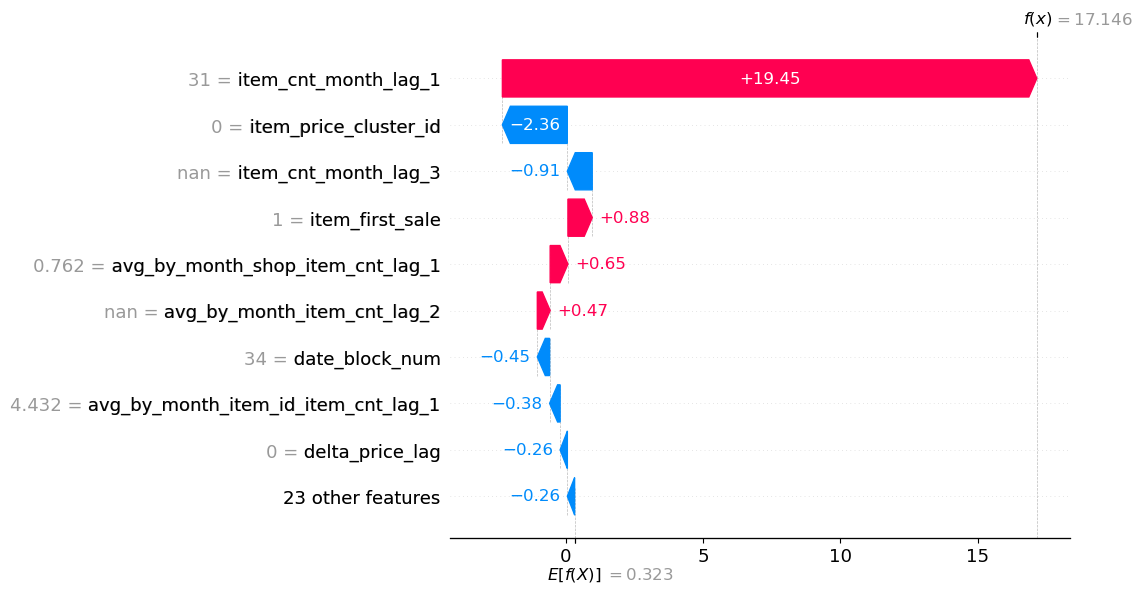

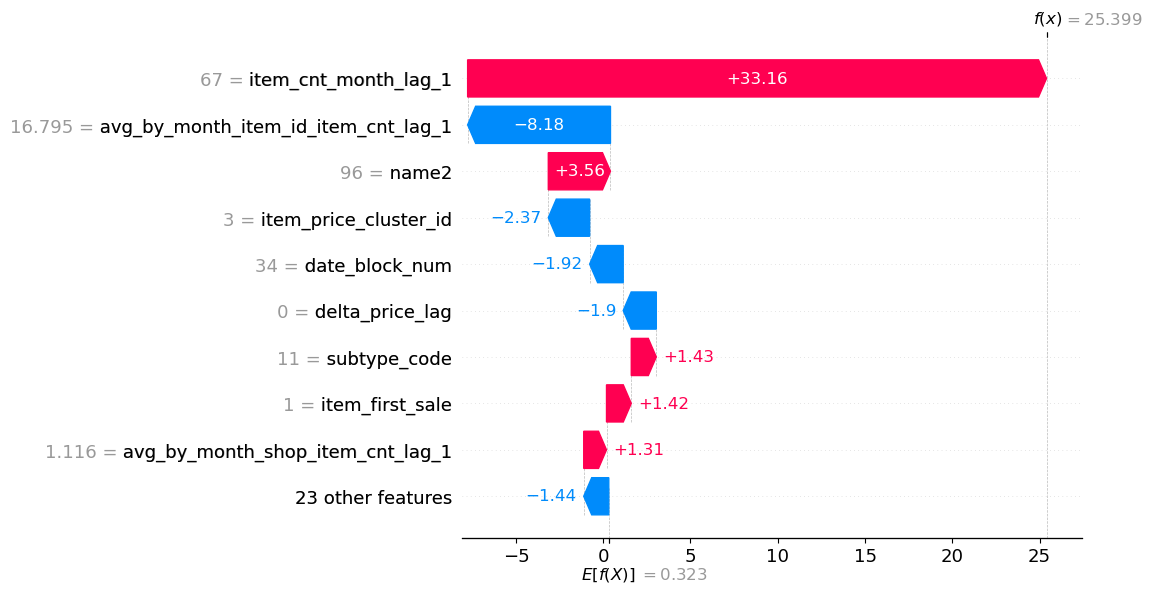

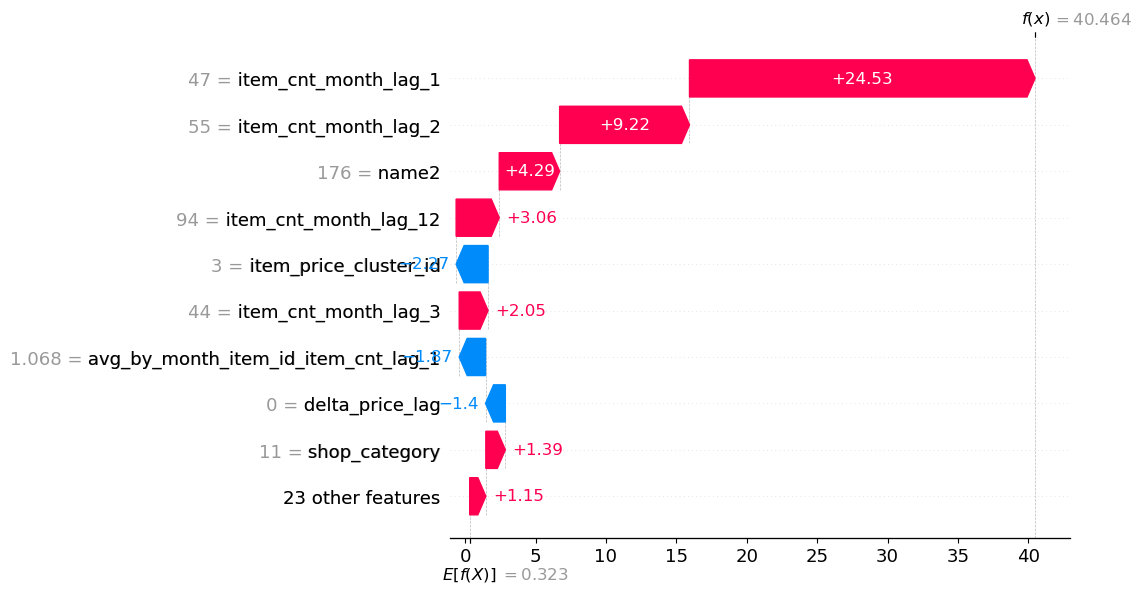

CPU times: total: 4min 13s
Wall time: 3min 5s


In [174]:
%%time

# train model
model=cb.CatBoostRegressor(iterations=30)
model.fit(data['train_data'].drop(columns='item_cnt_month'), data['train_data'].item_cnt_month)

# calculate SHAP values for test_data
explainer = shap.Explainer(model)
shap_values = explainer(data['test_data'])

# collect SHAP values by item_id/shop_id combinations
shap_info = {}

for i in range(len(shap_values)):
    shap_info[tuple([int(float_num) for float_num in shap_values[i].data[1:3]])] = shap_values[i]
    
# select shops/items combinations
submission_examples = []
for i in range(data['submission_example'].shape[0]):
    submission_examples.append( tuple(data['submission_example'].iloc[i][1:3]) )

# create dict with ID <-> shop_id, item_id connection
ID_by_shop_item = {'ID': [int(i) for i in data['submission_example'].ID],
        'shop_id': [int(i) for i in data['submission_example'].shop_id],
        'item_id': [int(i) for i in data['submission_example'].item_id]}
df = pd.DataFrame(ID_by_shop_item)
ID_to_shop_item = dict(zip(df['ID'], zip(df['shop_id'], df['item_id'])))

# select predictions with high sales
result = data['test_data'].join(pd.DataFrame(index=data['test_data'].index, data=model.predict(data['test_data'].values),\
                                           columns=['item_cnt_month']))\
                                                [['item_id', 'shop_id', 'item_cnt_month']].\
                                merge(data['submission_example'], on=['shop_id', 'item_id'], how='right')\
                    .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID').fillna(0)
predictions_with_high_sales = result.sort_values(by=['item_cnt_month'], ascending=False)[:100]

# visualize SHAP values for submission predictions with high sales
counter = 0
while counter < 3:
    random_ID_with_high_sales = ID_to_shop_item[int(predictions_with_high_sales.iloc[random.randint(1, 100)].ID)]
    if random_ID_with_high_sales in shap_info.keys():
        counter +=1
        shap.plots.waterfall(shap_info[random_ID_with_high_sales])


In [176]:
%%time
# visualize SHAP values aggregated by all predictions
shap.plots.force(shap_values[:100])

CPU times: total: 0 ns
Wall time: 29 ms


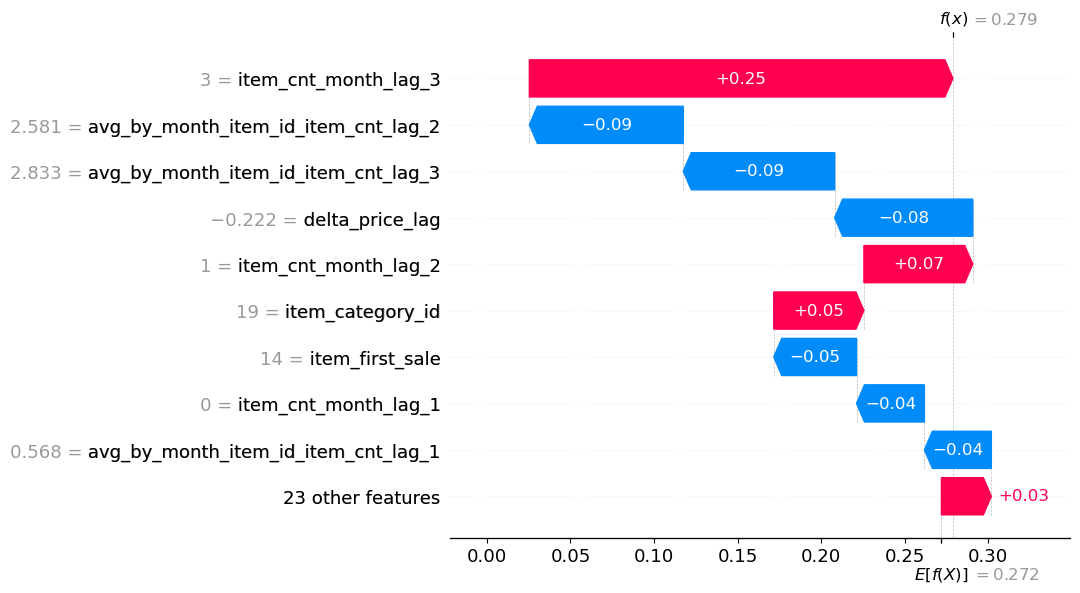

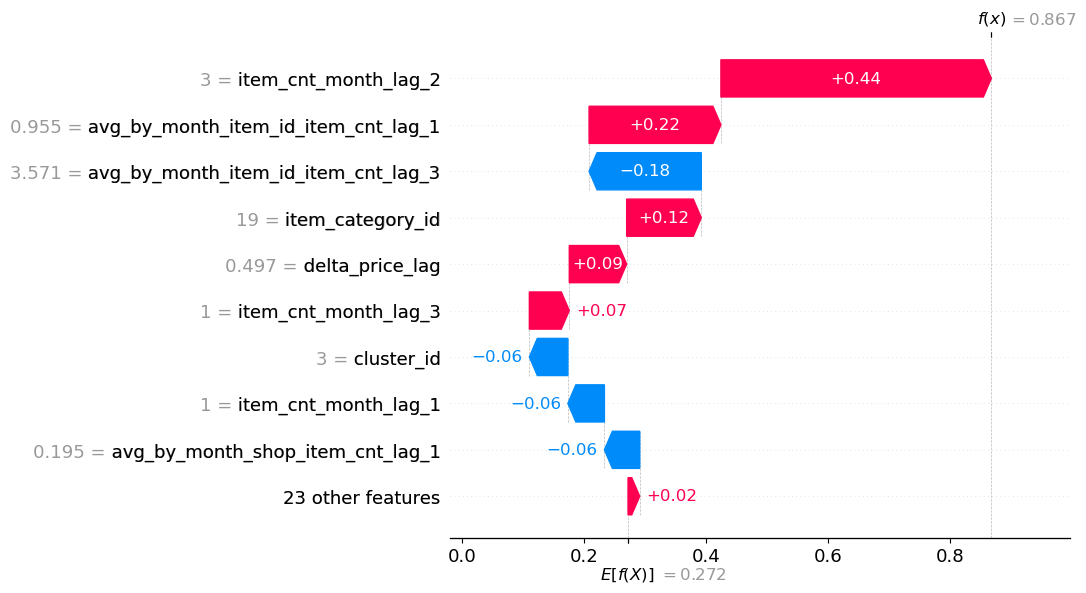

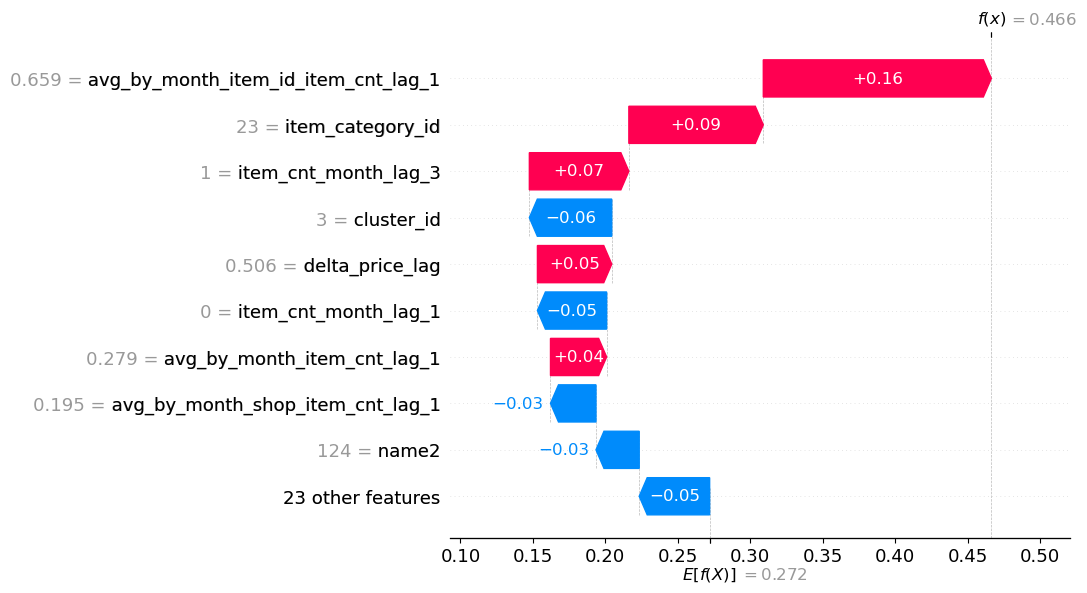

In [149]:
# visualize SHAP values for all submission predictions
counter = 0
for ID in submission_examples:
    if ID in shap_info.keys():
        counter +=1
        shap.plots.waterfall(shap_info[ID])
    if counter == 3:
        break